# Intrusion Detection
## Erkennung von auffälligen Netz-Aktivitäten

### Gelabelte Netzwerkdaten classifiziert nach "normal" bzw "abnormal"

In [54]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
data = pd.read_csv('Train_data.csv')
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


### Encoding kategorischer Daten

In [55]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
categorical = data.select_dtypes(include=['object']).copy()
data.drop(data.select_dtypes(include=['object']),axis=1,inplace=True)
categorical = categorical.apply(encoder.fit_transform)
data = pd.concat([data,categorical],axis=1)
data.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type,service,flag,class
0,0,491,0,0,0,0,0,0,0,0,...,0.17,0.00,0.00,0.00,0.05,0.00,1,19,9,1
1,0,146,0,0,0,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.00,0.00,2,41,9,1
2,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,1,46,5,0
3,0,232,8153,0,0,0,0,0,1,0,...,0.03,0.04,0.03,0.01,0.00,0.01,1,22,9,1
4,0,199,420,0,0,0,0,0,1,0,...,0.00,0.00,0.00,0.00,0.00,0.00,1,22,9,1


### Aufteilung in Training- und Evaluierungsdaten

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop('class', 1), data['class'], test_size = .2, random_state=10)

### Training eines Random Forest Classifiers zur Identifikation besonders wichtiger Features

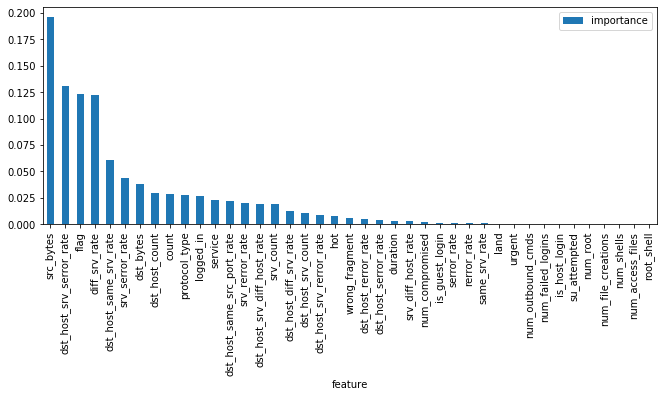

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

# fit random forest classifier on the training set
rfc.fit(X_train, y_train)
# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':X_train.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar()

### Sammlung der wichtigsten 15 Features zum Trainining der Modelle

In [58]:
from sklearn.feature_selection import RFE
import itertools
rfc = RandomForestClassifier()

# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['src_bytes',
 'dst_bytes',
 'hot',
 'count',
 'srv_count',
 'diff_srv_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_serror_rate',
 'protocol_type',
 'service',
 'flag']

### Parametrisierung und Training der Modelle
#### Verwendete Modelle:

* Random Forest Classifier
* K Nearest Neighbors Classifier
* Logistic Regression
* Naive Bayes Classifier for Multivariate Bernoulli Models
* Decision Tree Classifier

In [59]:
from sklearn.naive_bayes import BernoulliNB
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

#Train Random Forest Classifier
RF_Classifier = RandomForestClassifier(n_jobs=-1, random_state=0)
RF_Classifier.fit(X_train, y_train)

# Train KNeighborsClassifier Model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train, y_train)

# Train LogisticRegression Model
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier.fit(X_train, y_train)

# Train Gaussian Naive Baye Model
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, y_train)

# Train Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

### Report der trainierten Modelle

In [60]:
from sklearn import metrics

models = []
models.append(('Random Forest Classifier', RF_Classifier))
models.append(('Naive Baye Classifier', BNB_Classifier))
models.append(('Decision Tree Classifier', DTC_Classifier))
models.append(('KNeighborsClassifier', KNN_Classifier))
models.append(('LogisticRegression', LGR_Classifier))

for i, v in models:
    scores = cross_val_score(v, X_train, y_train, cv=10)
    accuracy = metrics.accuracy_score(y_test, v.predict(X_test))
    confusion_matrix = metrics.confusion_matrix(y_test, v.predict(X_test))
    classification = metrics.classification_report(y_test, v.predict(X_test))
    print()
    print('============================== {} Model Test Results =============================='.format(i))
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification)
    print()



============================== Random Forest Classifier Model Test Results ==============================

Cross Validation Mean Score:
 0.9966259991552301

Model Accuracy:
 0.9976185751141099

Confusion matrix:
 [[2352    6]
 [   6 2675]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2358
           1       1.00      1.00      1.00      2681

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039



============================== Naive Baye Classifier Model Test Results ==============================

Cross Validation Mean Score:
 0.8951525163930866

Model Accuracy:
 0.8974002778329033

Confusion matrix:
 [[2006  352]
 [ 165 2516]]

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.85      0.89      2358
           1       0.88      0.94 

#### Sehr gute Ergebnisse für:
* Random Forest
* Decision Tree
* K Nearest Neighbos

#### Gute Ergebnisse für:
* Naive Bayes
* Logistic Regression


### Entscheidungsbaum

In [ ]:
from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image

estimator = DTC_Classifier
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'anormal'
y_train_str[y_train_str == '1'] = 'normal'
y_train_str = y_train_str.values
export_graphviz(estimator, out_file='tree.dot',
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True,
                label='root',
                precision = 2, filled = True)
graph, = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

Image(filename = 'tree.png')

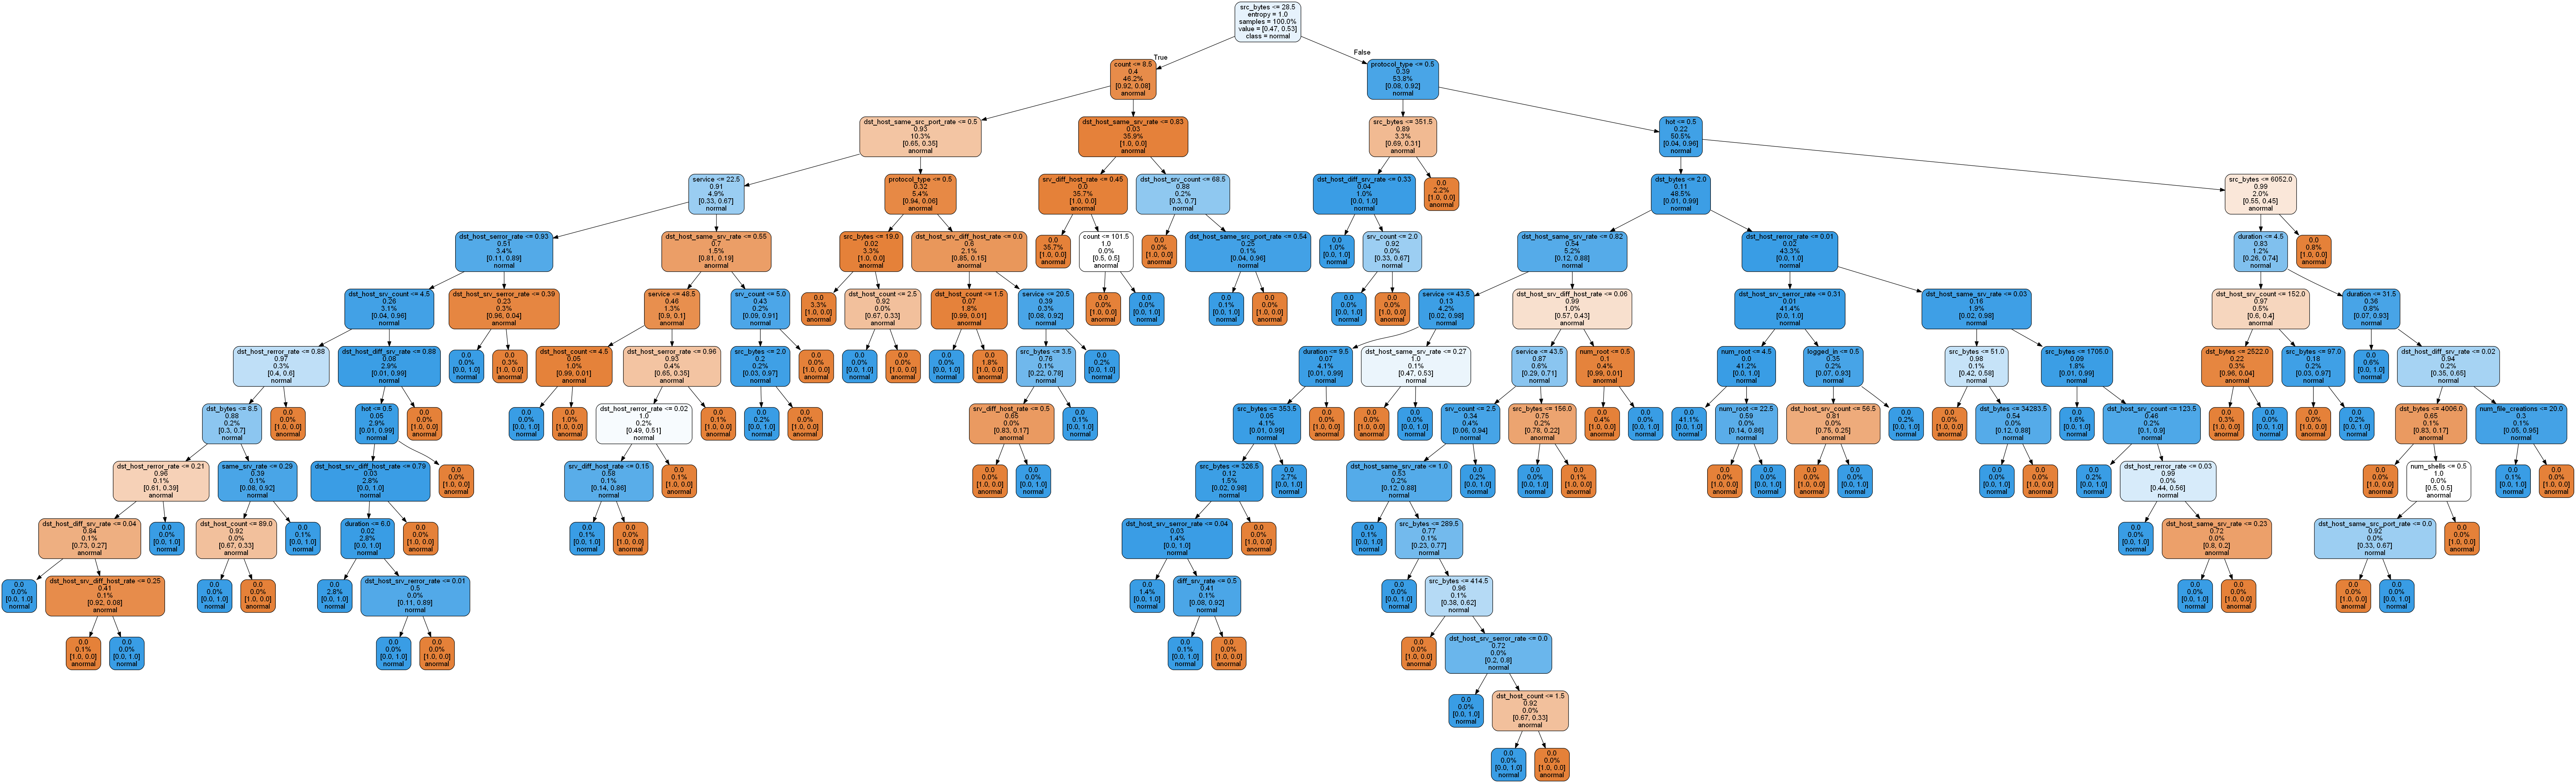

In [61]:
from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image

estimator = DTC_Classifier
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'anormal'
y_train_str[y_train_str == '1'] = 'normal'
y_train_str = y_train_str.values
export_graphviz(estimator, out_file='tree.dot',
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True,
                label='root',
                precision = 2, filled = True)
graph, = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

Image(filename = 'tree.png')

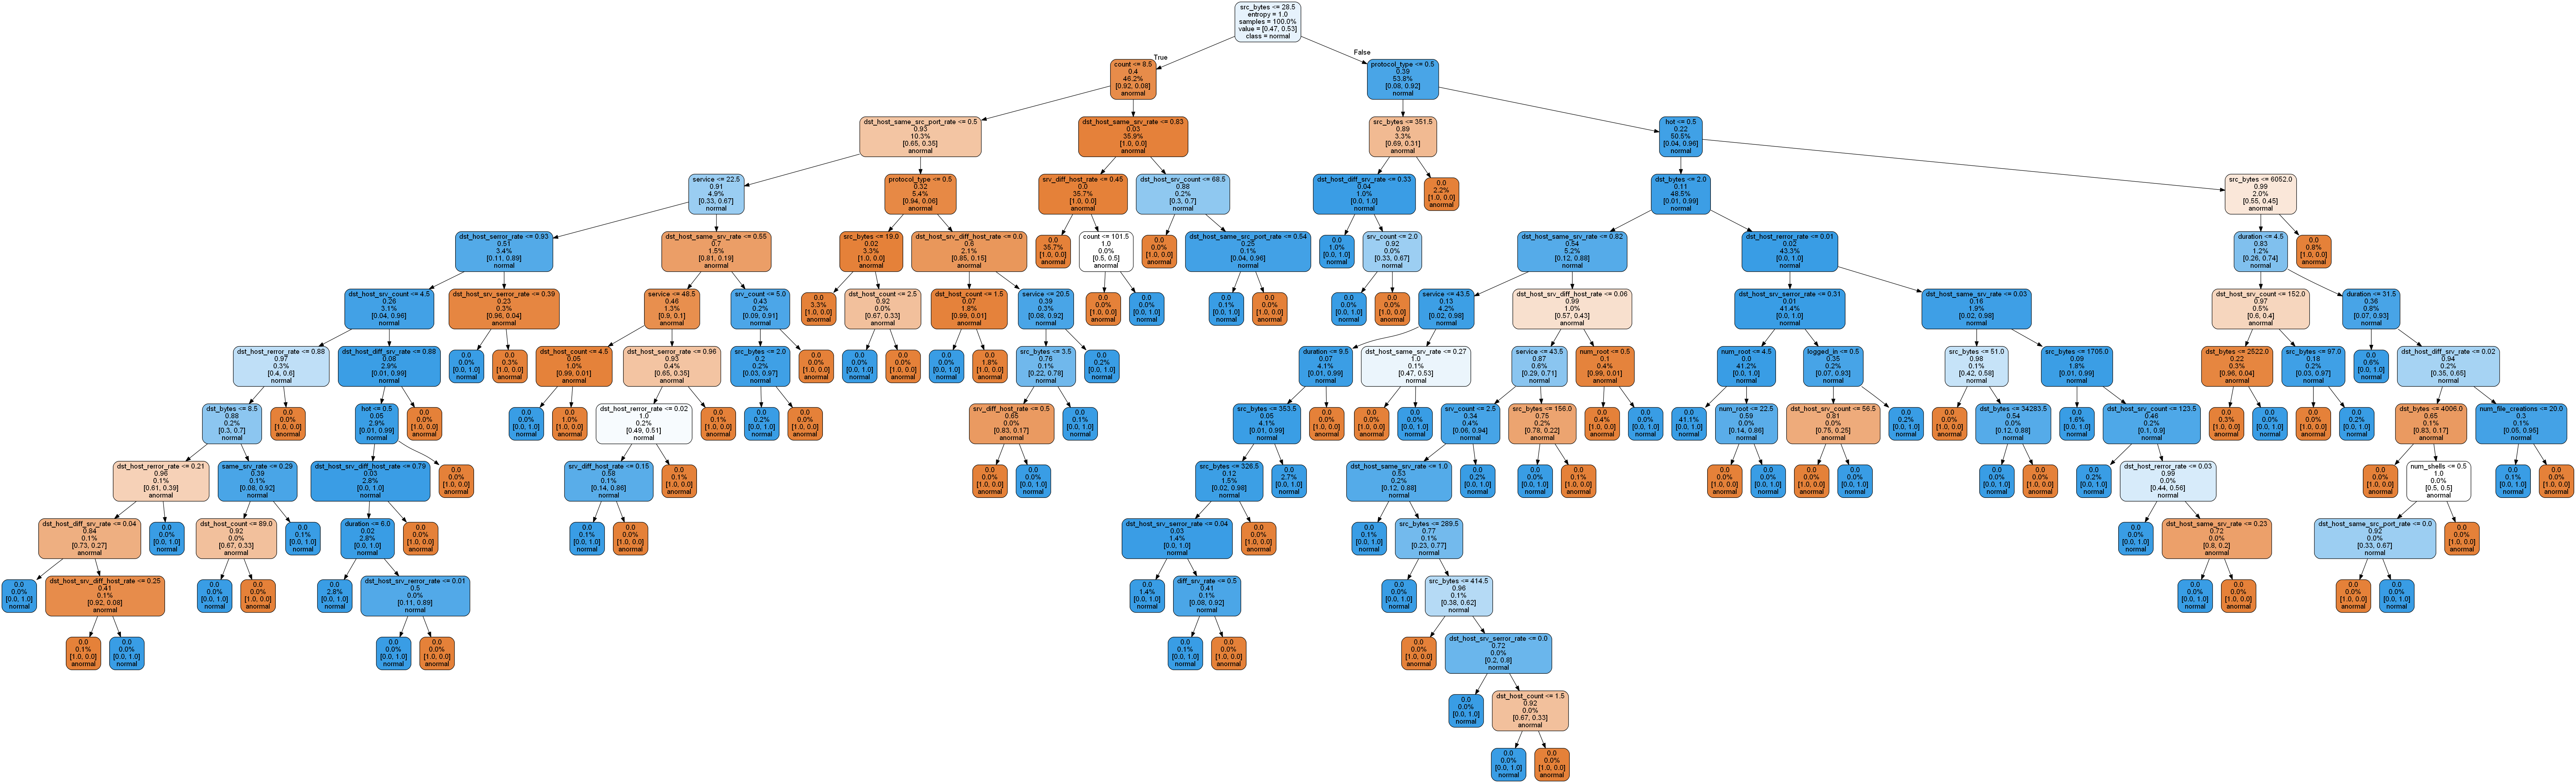

In [8]:
from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image

estimator = DTC_Classifier
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'anormal'
y_train_str[y_train_str == '1'] = 'normal'
y_train_str = y_train_str.values
export_graphviz(estimator, out_file='tree.dot',
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True,
                label='root',
                precision = 2, filled = True)
graph, = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

Image(filename = 'tree.png')